In [1]:
%env CUDA_HOME="/pkgs/cuda-11.2"

env: CUDA_HOME="/pkgs/cuda-11.2"


In [2]:
import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt
from argparse import Namespace

In [3]:
from models.psp2 import pSpSGXL

In [4]:
opts = Namespace()
opts.stylegan_weights = "../stylegan-xl/pretrained_models/ffhq256.pkl"
opts.checkpoint_path="exps/ffhq_sgxl_256_2/checkpoints/best_model.pt"
opts.stylegan_size=256
opts.encoder_type="Encoder4Editing"
opts.decoder_type="stylegan-xl"
opts.start_from_latent_avg=True
opts.device=torch.device("cuda")
opts.dataset_type='ffhq_encode'
opts.stem_size=16
opts.head_layers=4
opts.syn_layers=10
opts.sgxl=True

In [5]:
psp_model = pSpSGXL(opts).to(opts.device)

/h/kaselby/.conda/envs/sgxl/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading e4e over the pSp framework from checkpoint: exps/ffhq_sgxl_256_2/checkpoints/best_model.pt


In [6]:
from datasets.inference_dataset import InferenceDataset
from configs import data_configs

In [7]:
dataset_args = data_configs.DATASETS[opts.dataset_type]

transforms_dict = dataset_args['transforms'](opts).get_transforms()
images_path = dataset_args['test_source_root']
test_dataset = InferenceDataset(root=images_path,
                                transform=transforms_dict['transform_test'],
                                preprocess=None,
                                opts=opts)

In [8]:
from utils.common import tensor2im

In [46]:
x=torch.stack([test_dataset[i] for i in range(10, 20)], dim=0)

In [ ]:
out=psp_model(x.cuda())

In [11]:
out.size()

torch.Size([1, 3, 256, 256])

In [9]:
imgs = []
outs = []
indices = torch.randperm(len(test_dataset))
for i in range(10):
    inp = test_dataset[indices[i]].unsqueeze(0)
    with torch.no_grad():
        out = psp_model(inp.cuda()).cpu()
    imgs.append(inp)
    outs.append(out)

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


In [10]:
import einops
imgs = torch.cat(imgs, dim=0)
outs = torch.cat(outs, dim=0)

imgs2 = einops.rearrange(imgs, 'n c y x -> c (n y) x')
outs2 = einops.rearrange(outs, 'n c y x -> c (n y) x')

In [12]:
import matplotlib.pyplot as plt

(-0.5, 255.5, 2559.5, -0.5)

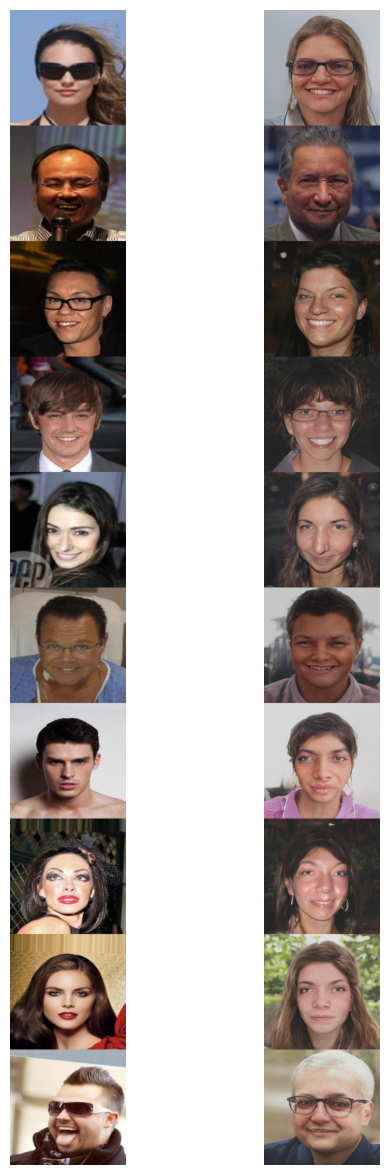

In [23]:
fig, axes = plt.subplots(1,2, figsize=(6, 15))
axes[0].imshow(tensor2im(imgs2))
axes[0].axis('off')
axes[1].imshow(tensor2im(outs2))
axes[1].axis('off')

In [12]:
imgs.size()

torch.Size([10, 3, 256, 256])

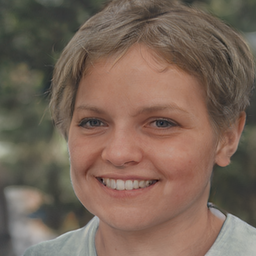

In [41]:
tensor2im(out[0])

In [ ]:
psp_model.encoder(x).size()

In [ ]:
psp_model.decoder

In [ ]:
from styleganxl.legacy import load_network_pkl
from styleganxl.dnnlib.util import open_url

In [ ]:
with open_url("../stylegan-xl/pretrained-models/ffhq256.pkl") as f:
    G256 = load_network_pkl(f)['G_ema']

In [ ]:
with open_url("../stylegan-xl/pretrained-models/ffhq1024.pkl") as f:
    G1024 = load_network_pkl(f)['G_ema']

In [ ]:
G256.num_layers

In [ ]:
G1024.num_layers

In [ ]:
G256.mapping(torch.randn(10,64), None).size()

In [ ]:
G1024.mapping(torch.randn(10,64), None).size()

In [ ]:
G256

In [ ]:
import math
syn_layers=10
head_layers=4
log_size = int(math.log(opts.stylegan_size // opts.stem_size, 2))
style_count = syn_layers + (head_layers - 2) * log_size

In [ ]:
style_count

In [ ]:
G256.num_ws

In [4]:
import os
from PIL import Image

In [6]:
rundir="exps/ffhq_sgxl_256_jun16/logs/images/test/faces"

In [7]:
len(os.listdir(rundir))

805

In [4]:
sorted(os.listdir(rundir))[-2]

'9999_20000.jpg'

In [9]:
imgpaths = os.listdir(rundir)

In [7]:
imgpaths[1]

'1546_20000.jpg'

In [8]:
import re

In [11]:
re.search(r'([0-9]+)_([0-9]+).jpg', imgpaths[1]).groups()

('1546', '20000')

In [10]:
import re
imgs_by_step={}
for imgpath in imgpaths:
    subscript, step = re.search(r'([0-9]+)_([0-9]+).jpg', imgpath).groups()
    subscript, step = int(subscript), int(step)
    if step not in imgs_by_step:
        imgs_by_step[step] = {}
    path = os.path.join(rundir, imgpath)
    imgs_by_step[step][subscript] = path
    
    
    

25324

In [11]:
imgs_by_step.keys()

dict_keys([130000, 50000, 30000, 20000, 160000, 10000, 120000, 80000, 60000, 70000, 90000, 40000, 140000, 110000, 100000, 150000, 0])

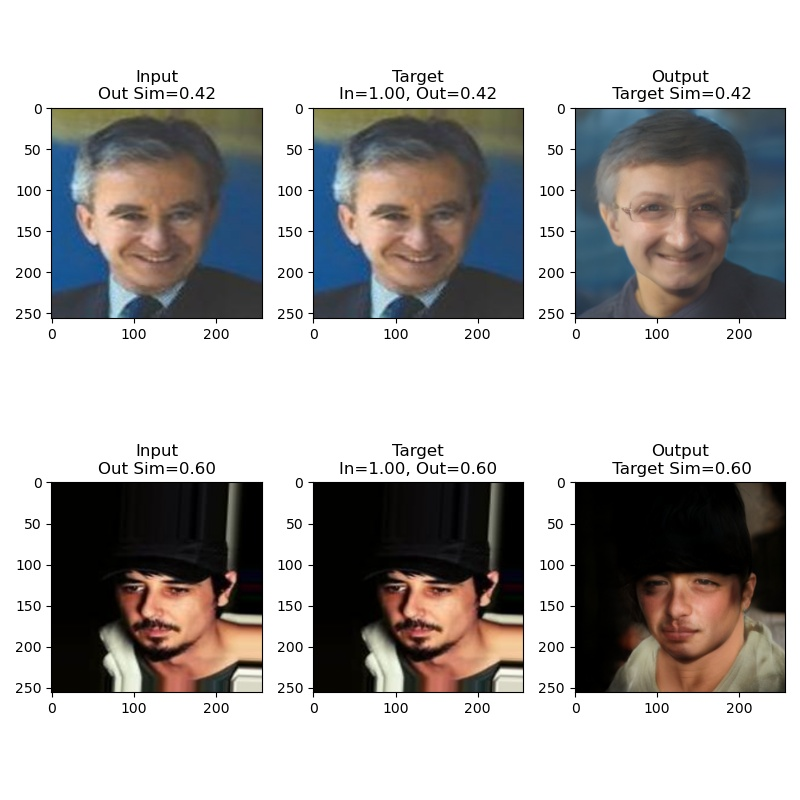

In [20]:
Image.open(list(imgs_by_step[160000].values())[0])

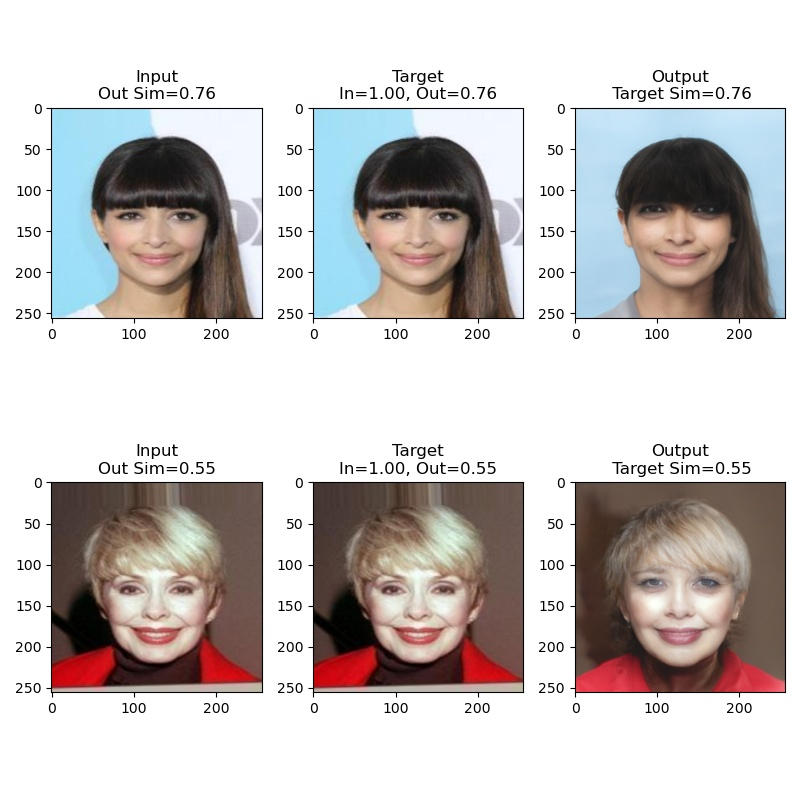

In [21]:
Image.open(list(imgs_by_step[160000].values())[1])

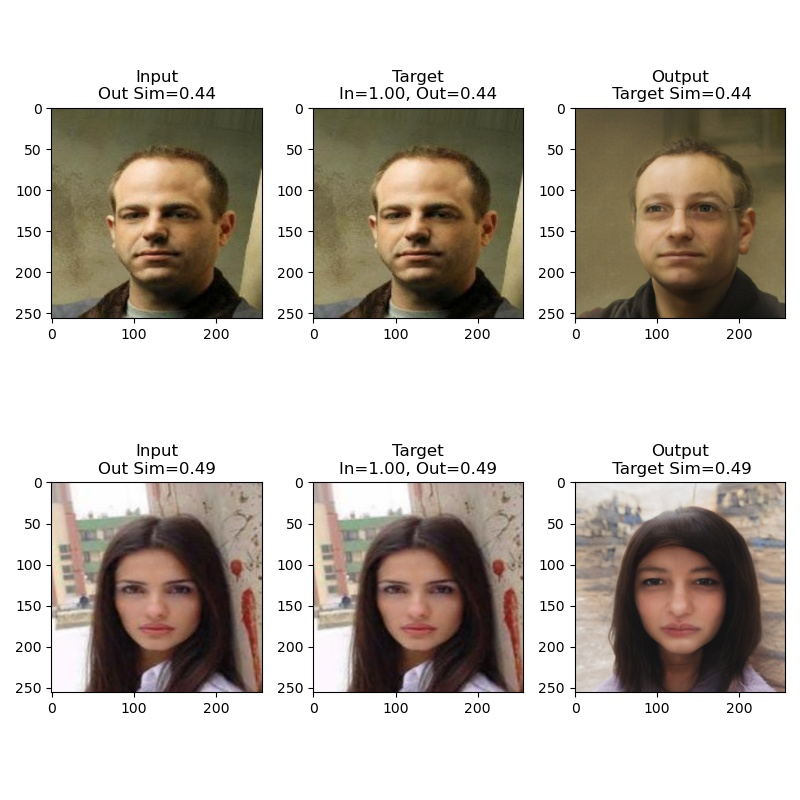

In [22]:
Image.open(list(imgs_by_step[160000].values())[2])

In [19]:
import torch
test=torch.load("/checkpoint/kaselby/ffhq_sgxl_256_2/ckpt.pt")

In [20]:
test.keys()

dict_keys(['state_dict', 'opts', 'latent_avg', 'global_step', 'optimizer', 'best_val_loss', 'discriminator_state_dict', 'discriminator_optimizer_state_dict'])

In [21]:
test['global_step']

0

In [22]:
test['opts']

{'exp_dir': 'exps/ffhq_sgxl_256_2',
 'dataset_type': 'ffhq_encode',
 'encoder_type': 'Encoder4Editing',
 'batch_size': 8,
 'test_batch_size': 8,
 'workers': 4,
 'test_workers': 4,
 'learning_rate': 0.0001,
 'optim_name': 'ranger',
 'train_decoder': False,
 'start_from_latent_avg': True,
 'lpips_type': 'alex',
 'lpips_lambda': 0.8,
 'id_lambda': 0.5,
 'l2_lambda': 1.0,
 'stylegan_weights': '/h/kaselby/stylegan-xl/pretrained_models/ffhq256.pkl',
 'stylegan_size': 256,
 'checkpoint_path': None,
 'max_steps': 200000,
 'image_interval': 100,
 'board_interval': 50,
 'val_interval': 10000,
 'save_interval': 200000,
 'w_discriminator_lambda': 0.1,
 'w_discriminator_lr': 2e-05,
 'r1': 10,
 'd_reg_every': 16,
 'use_w_pool': True,
 'w_pool_size': 50,
 'delta_norm': 2,
 'delta_norm_lambda': 0.0002,
 'progressive_steps': [0,
  20000,
  22000,
  24000,
  26000,
  28000,
  30000,
  32000,
  34000,
  36000,
  38000,
  40000,
  42000,
  44000],
 'progressive_start': 20000,
 'progressive_step_every': 20